# Introduction

A beach, a city building and a tree in a field seem simple enough images that any human being could classify between belonging to a category for only beach images or not. There are several strategies that humans implement subconsciously to achieve this task. For instance, we can take in several details from an image at once, like the type of clothing people wear, the soil type, or the elements present in the picture, and determine the category to which the image belongs. Nevertheless, if this task was given to a computer, the same processes humans use might be less directly applicable.

Computers can still differentiate images, but that process differs from the ones humans use. Therefore, we will explore how computers can visualise and analyse an image. For this report, we aim to create a machine-learning pipeline that analyses images from our digital archive. We will use three logistic regression models to determine whether the pictures belong to a category. Each model corresponds to one category. The categories are Beach, City, and Nature. Ultimately, we will compare each model's performance and conclude the computer's image analysis ability.

# Data overview

Firstly, we have compiled 83 images (23 beach images, 27 city images and 33 nature images). The pictures came directly from our phone gallery and were taken across our Minerva journey. The photos were taken in several countries, including Argentina, Brazil, Germany, India, Mexico, South Korea, Taiwan, Turkey and the US, Taiwan. To sample the images, we sifted through our phone gallery and selected images from each category, where we determined the photos represented the category. We avoided ambiguities such as a park in a city that could be ambiguous in nature or city. We aimed to select images with as many variations as possible regarding their illumination, time of day, elements and angles.

Each image category is contained in a zip file in Google Drive. We download them using the gdown library and extract them using zipfile. Additionally, we will augment our data to account for our relatively small dataset size. We will perform rotations of 90°, - 90° and 180°. We will also flip the images horizontally and add random noise to them. This leaves us with 492 images in total. Finally, we show a sample for each category.
We will keep a separate dataset for the grayscale and colour images, as we will use both in different models.

Starting data loading process...


Downloading...
From: https://drive.google.com/uc?id=1qM2MTllQfKvm8NweQKycM_KNQI6ckNSF
To: /home/bruno_alv/Notebooks/7 Berlin SF 2024/CS156/Assignments/CS156 - Pipeline - Second Draft/Beach.zip
100%|██████████| 23.2M/23.2M [00:02<00:00, 8.67MB/s]


Extracting Beach images...
Found 22 Beach images.



Downloading...
From (original): https://drive.google.com/uc?id=1I0J3MG9kgC8gYioxI8iSQRXJDhMnIuWO
From (redirected): https://drive.google.com/uc?id=1I0J3MG9kgC8gYioxI8iSQRXJDhMnIuWO&confirm=t&uuid=6b617ab0-2d03-4e8a-89cd-a78f8dbea01c
To: /home/bruno_alv/Notebooks/7 Berlin SF 2024/CS156/Assignments/CS156 - Pipeline - Second Draft/City.zip
100%|██████████| 51.3M/51.3M [00:08<00:00, 6.13MB/s]


Extracting City images...
Found 27 City images.



Downloading...
From (original): https://drive.google.com/uc?id=1maSDA0GIKwRLbvP73Me-tBXBQeX1KVDU
From (redirected): https://drive.google.com/uc?id=1maSDA0GIKwRLbvP73Me-tBXBQeX1KVDU&confirm=t&uuid=1c4742c6-c58c-4207-b5d8-582ae253d273
To: /home/bruno_alv/Notebooks/7 Berlin SF 2024/CS156/Assignments/CS156 - Pipeline - Second Draft/Nature.zip
100%|██████████| 107M/107M [00:11<00:00, 9.33MB/s] 


Extracting Nature images...
Found 33 Nature images.

Loading and augmenting images...
Processing 22 images for label: Beach
Processing 27 images for label: City
Processing 33 images for label: Nature
Combining datasets...
Shape of X_rgb: (492, 12288)
Shape of X_gray: (492, 4096)
Shape of y: (492,)
Displaying random colored samples from each category...


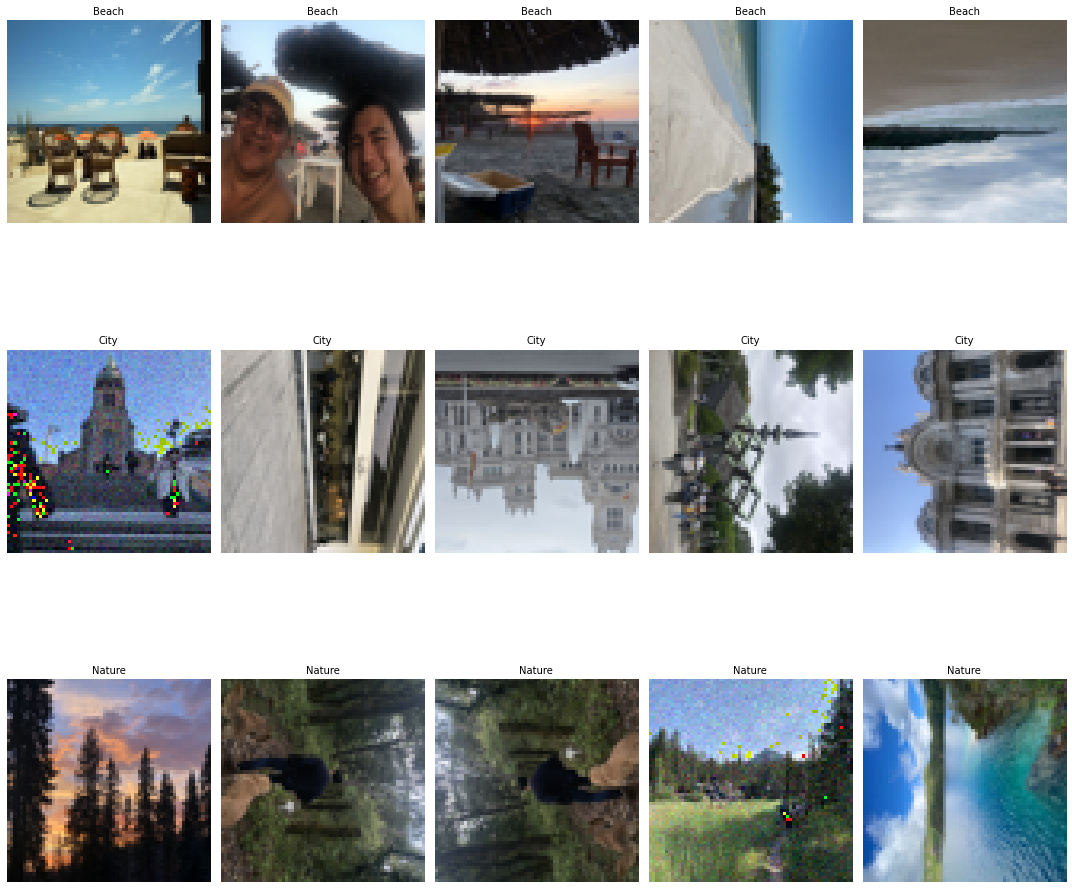

In [16]:
import gdown
import zipfile
import os
import random
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Google Drive links of the zip files (replace with actual file IDs)
Beach_url = 'https://drive.google.com/uc?id=1qM2MTllQfKvm8NweQKycM_KNQI6ckNSF'
City_url = 'https://drive.google.com/uc?id=1I0J3MG9kgC8gYioxI8iSQRXJDhMnIuWO'
Nature_url = 'https://drive.google.com/uc?id=1maSDA0GIKwRLbvP73Me-tBXBQeX1KVDU'

# Function to download and extract images from a Google Drive zip file
def download_and_extract_images(zip_url, output_dir):
    output_zip = f'{output_dir}.zip'
    print(f"Downloading {output_dir} images...")
    gdown.download(zip_url, output_zip, quiet=False)
    print(f"Extracting {output_dir} images...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    os.remove(output_zip)
    image_files = []
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    print(f"Found {len(image_files)} {output_dir} images.\n")
    return image_files

# Function to augment a single image
def augment_image(img):
    augmented_images = []
    augmented_images.append(img)  # Original image
    for angle in [90, -90, 180]:  # Rotations
        augmented_images.append(img.rotate(angle))
    augmented_images.append(ImageOps.mirror(img))  # Flip horizontally
    img_array = np.array(img)
    noise = np.random.normal(0, 10, img_array.shape).astype(np.uint8)  # Gaussian noise
    noisy_img = Image.fromarray(np.clip(img_array + noise, 0, 255))
    augmented_images.append(noisy_img)
    return augmented_images

# Function to load and augment images for RGB and grayscale
def load_and_augment_images(image_files, label_name):
    """
    Load and augment images, ensuring uniform shapes for all augmentations.
    
    Args:
        image_files (list): List of image file paths.
        label_name (str): Label to assign to the images.
    
    Returns:
        np.ndarray: Array of augmented RGB images.
        np.ndarray: Array of augmented grayscale images.
        np.ndarray: Array of corresponding labels.
    """
    grayscale_images = []
    rgb_images = []
    labels = []
    print(f"Processing {len(image_files)} images for label: {label_name}")
    
    for img_path in image_files:
        try:
            # Open the image
            img = Image.open(img_path).convert("RGB").resize((64, 64))  # Ensure consistent size and mode
            
            # Augment RGB images
            augmented_rgb = augment_image(img)
            for aug_img in augmented_rgb:
                resized_rgb = aug_img.resize((64, 64))  # Ensure consistent size
                rgb_array = np.array(resized_rgb).flatten()  # Flatten RGB
                if rgb_array.shape == (64 * 64 * 3,):  # Validate RGB shape
                    rgb_images.append(rgb_array)
                    labels.append(label_name)  # Add label to separate list
                else:
                    print(f"Skipped RGB image with shape {rgb_array.shape}: {img_path}")
            
            # Convert to grayscale and augment
            gray_img = img.convert("L")  # Convert to grayscale
            augmented_gray = augment_image(gray_img)
            for aug_img in augmented_gray:
                resized_gray = aug_img.resize((64, 64))  # Ensure consistent size
                gray_array = np.array(resized_gray).flatten()  # Flatten grayscale
                if gray_array.shape == (64 * 64,):  # Validate grayscale shape
                    grayscale_images.append(gray_array)
                else:
                    print(f"Skipped grayscale image with shape {gray_array.shape}: {img_path}")
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    
    # Ensure consistent NumPy arrays
    return np.array(rgb_images), np.array(grayscale_images), np.array(labels)

# Function to display random colored (RGB) samples with category labels
def display_random_colored_samples(X_rgb, y, categories, sample_size=5):
    """
    Displays random colored (RGB) image samples from each category with category labels.

    Args:
        X_rgb (np.ndarray): RGB dataset (flattened).
        y (np.ndarray): Corresponding labels.
        categories (list): List of categories to display samples for.
        sample_size (int): Number of random samples to display per category.
    """
    fig, axes = plt.subplots(len(categories), sample_size, figsize=(15, 5 * len(categories)))

    for i, category in enumerate(categories):
        # Filter data for the category
        category_indices = [idx for idx, label in enumerate(y) if label == category]
        random_indices = random.sample(category_indices, min(sample_size, len(category_indices)))

        for j, idx in enumerate(random_indices):
            img_array = X_rgb[idx].reshape(64, 64, 3).astype(np.uint8)  # Reshape to 64x64x3
            axes[i, j].imshow(img_array)
            axes[i, j].axis("off")
            axes[i, j].set_title(category, fontsize=10)  # Add category label as title
    
    plt.tight_layout()
    plt.show()

# Download and extract images for Beach, City, and Nature
print("Starting data loading process...")
Beach_images = download_and_extract_images(Beach_url, 'Beach')
City_images = download_and_extract_images(City_url, 'City')
Nature_images = download_and_extract_images(Nature_url, 'Nature')

# Load and augment images
print("Loading and augmenting images...")
beach_rgb, beach_gray, beach_labels = load_and_augment_images(Beach_images, "Beach")
city_rgb, city_gray, city_labels = load_and_augment_images(City_images, "City")
nature_rgb, nature_gray, nature_labels = load_and_augment_images(Nature_images, "Nature")

# Combine datasets
print("Combining datasets...")
X_rgb = np.vstack((beach_rgb, city_rgb, nature_rgb))
X_gray = np.vstack((beach_gray, city_gray, nature_gray))
y = np.hstack((beach_labels, city_labels, nature_labels))

print("Shape of X_rgb:", X_rgb.shape)
print("Shape of X_gray:", X_gray.shape)
print("Shape of y:", y.shape)

# Display random colored (RGB) samples
categories = ["Beach", "City", "Nature"]
print("Displaying random colored samples from each category...")
display_random_colored_samples(X_rgb, y, categories)

# Data Preparation and Description

Next, we will transform our data to be processable by our computer. First, we have already split each image into a 64 by 64 grid representing 4096 pixels.

Furthermore, we prevent data processing errors by removing all corrupt or unreadable images from the dataset. These images are readable by the computer but experience a problem when loaded into the notebook. As this is part of our data processing, we included it in the final code.

Finally, we flatten each image's 4096 pixels into an array. Then, we add an entry for their respective category's label. We add each array into a data frame. This data frame's head is visualised.

In [17]:
import pandas as pd

# Convert datasets into separate DataFrames for each RGB component and Grayscale
def create_dataframes_with_separate_rgb(X_rgb, X_gray, y):
    """
    Converts datasets into separate DataFrames for each RGB component and Grayscale.

    Args:
        X_rgb (np.ndarray): Augmented RGB images (flattened).
        X_gray (np.ndarray): Augmented grayscale images (flattened).
        y (np.ndarray): Corresponding labels.

    Returns:
        dataframes (dict): Dictionary containing separate DataFrames for R, G, B, and Grayscale components.
    """
    print("Converting datasets into separate DataFrames for each RGB component...")

    # Separate RGB components
    num_pixels = X_rgb.shape[1] // 3  # Calculate number of pixels per component
    R = X_rgb[:, :num_pixels]  # Red component
    G = X_rgb[:, num_pixels:num_pixels * 2]  # Green component
    B = X_rgb[:, num_pixels * 2:]  # Blue component

    # Create individual DataFrames for each component
    df_R = pd.DataFrame(R, columns=[f"R_{i}" for i in range(num_pixels)])
    df_R["label"] = y

    df_G = pd.DataFrame(G, columns=[f"G_{i}" for i in range(num_pixels)])
    df_G["label"] = y

    df_B = pd.DataFrame(B, columns=[f"B_{i}" for i in range(num_pixels)])
    df_B["label"] = y

    # Create Grayscale DataFrame
    df_gray = pd.DataFrame(X_gray, columns=[f"Pixel_{i}" for i in range(X_gray.shape[1])])
    df_gray["label"] = y

    # Store DataFrames in a dictionary
    dataframes = {
        "Red": df_R,
        "Green": df_G,
        "Blue": df_B,
        "Grayscale": df_gray,
    }

    return dataframes

# Create separate DataFrames for each RGB component and Grayscale
dataframes = create_dataframes_with_separate_rgb(X_rgb, X_gray, y)

# Accessing individual DataFrames
df_R = dataframes["Red"]
df_G = dataframes["Green"]
df_B = dataframes["Blue"]
df_gray = dataframes["Grayscale"]

# Display shapes of the DataFrames
print(f"Shape of Red DataFrame: {df_R.shape}")
print(f"Shape of Green DataFrame: {df_G.shape}")
print(f"Shape of Blue DataFrame: {df_B.shape}")
print(f"Shape of Grayscale DataFrame: {df_gray.shape}")

Converting datasets into separate DataFrames for each RGB component...
Shape of Red DataFrame: (492, 4097)
Shape of Green DataFrame: (492, 4097)
Shape of Blue DataFrame: (492, 4097)
Shape of Grayscale DataFrame: (492, 4097)


Following, we show histograms of the pixel intensities across each RGB and Grayscale component to compare how different each category is across their components compared to the others.

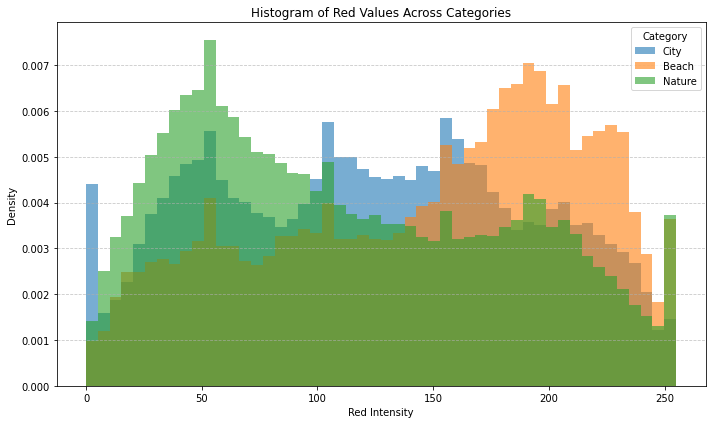

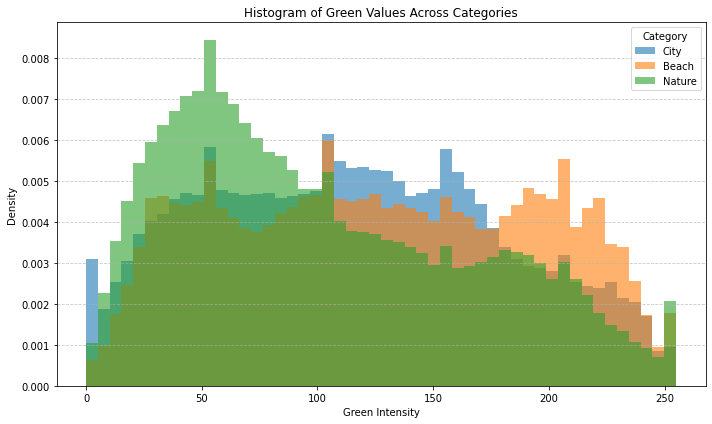

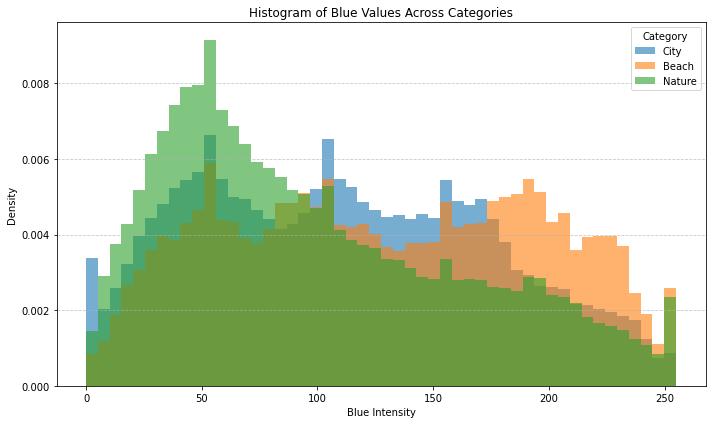

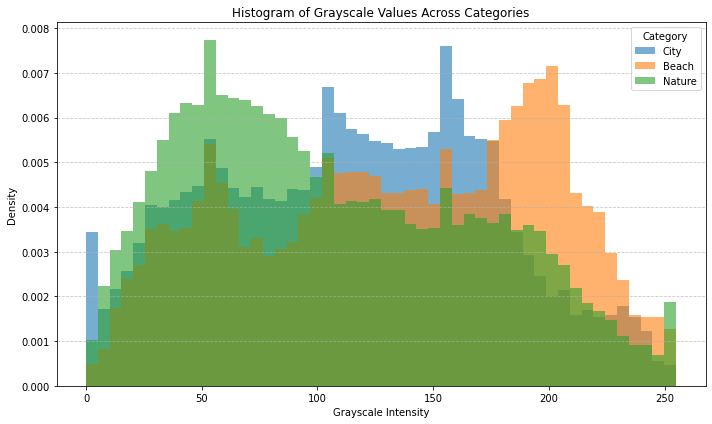

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import mode

# Function to plot histograms for all components across categories
def plot_histograms(dataframes, categories):
    """
    Plot histograms of Red, Green, Blue, and Grayscale values for all categories.
    
    Args:
        dataframes (dict): Dictionary containing separate DataFrames for 'Red', 'Green', 'Blue', and 'Grayscale'.
        categories (list): List of category names (e.g., ['City', 'Beach', 'Nature']).
    """
    components = dataframes.keys()

    for component in components:
        plt.figure(figsize=(10, 6))
        
        for category in categories:
            # Filter data for the current category
            category_data = dataframes[component][dataframes[component]['label'] == category].drop(columns=['label'])

            # Flatten data across all pixels
            values = category_data.values.flatten()

            plt.hist(values, bins=50, alpha=0.6, label=category, density=True)
        
        plt.title(f"Histogram of {component} Values Across Categories")
        plt.xlabel(f"{component} Intensity")
        plt.ylabel("Density")
        plt.legend(title="Category")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Compute statistics across all categories
categories = ['City', 'Beach', 'Nature']

# Plot histograms
plot_histograms(dataframes, categories)

Firstly, we see that the city category is relatively normally distributed for the grayscale component, and the beach categories are similar in their distribution and skewness for the grayscale component. This is true for their green and blue components. Furthermore, the nature category is consistently skewed to the right across all components. Finally, the city category's red component distribution appears more uniform than the other categories, and the beach category's red component is skewed to the left.

These insights say little about our data. We could hypothesise that the grayscale components are different enough across each category to allow our models to differentiate easily. For the RGB components, as the nature category is consistently different across the three of them, we might see higher results differentiating this category from the others.

## Data Normalisation and Statistics

Now, we will normalise our data frames to make it easier for our models to converge. Furthermore, we started exploring the each category's descriptive stats across each component. We realise that the Beach category is the most different compared to the other two across most components. The standard deviation across all categories seem to fall within the same range of [2.3 and 2.6].

In [19]:
import numpy as np
from scipy.stats import mode

# Function to normalize the data
def normalize_dataframe(df):
    """
    Normalize pixel intensity values in a DataFrame to the range [0, 1].
    
    Args:
        df (pd.DataFrame): DataFrame containing pixel values and labels.
    
    Returns:
        pd.DataFrame: Normalized DataFrame with pixel values in [0, 1].
    """
    pixel_columns = df.drop(columns=['label']).columns  # No 'component' column
    df[pixel_columns] = df[pixel_columns] / 255.0  # Normalize to [0, 1]
    return df

# Normalize all components in the dataframes dictionary
def normalize_dataframes(dataframes):
    """
    Normalize all pixel intensity values in the dataframes for each component.
    
    Args:
        dataframes (dict): Dictionary containing separate DataFrames for 'Red', 'Green', 'Blue', and 'Grayscale'.
    
    Returns:
        dict: Dictionary of normalized DataFrames.
    """
    normalized_dataframes = {}
    for component, df in dataframes.items():
        normalized_dataframes[component] = normalize_dataframe(df.copy())
    return normalized_dataframes

# Function to compute statistics for all categories and components
def compute_statistics_across_categories(dataframes, categories):
    """
    Compute statistics for all components (Red, Green, Blue, Grayscale) across all categories.
    
    Args:
        dataframes (dict): Dictionary containing separate DataFrames for 'Red', 'Green', 'Blue', and 'Grayscale'.
        categories (list): List of category names (e.g., ['City', 'Beach', 'Nature']).
    
    Returns:
        dict: Dictionary of statistics for each component across all categories.
    """
    all_stats = {}

    for category in categories:
        stats = {}

        for component, df in dataframes.items():
            # Filter data for the current category
            category_data = df[df['label'] == category].drop(columns=['label'])  # No 'component' column

            # Flatten data across all pixels
            values = category_data.values.flatten()

            stats[component] = {
                'mean': values.mean(),
                'mode': mode(values, keepdims=True).mode[0],
                'median': np.median(values),
                'std': values.std()
            }
        all_stats[category] = stats

    return all_stats

# Function to print statistics
def print_statistics(all_stats):
    """
    Print the computed statistics for all components across all categories.
    
    Args:
        all_stats (dict): Dictionary of statistics for each component across all categories.
    """
    for category, stats in all_stats.items():
        print(f"--- {category} Statistics ---")
        for component, values in stats.items():
            print(f"{component}: Mean={values['mean']:.4f}, Mode={values['mode']:.4f},"+
                  f"Median={values['median']:.4f}, Std={values['std']:.4f}")
        print()

# Normalize all DataFrames
print("Normalizing data...")
normalized_dataframes = normalize_dataframes(dataframes)

# Compute statistics across all categories using normalized data
categories = ['City', 'Beach', 'Nature']
all_stats = compute_statistics_across_categories(normalized_dataframes, categories)

# Print statistics
print_statistics(all_stats)

Normalizing data...
--- City Statistics ---
Red: Mean=0.4824, Mode=0.0039,Median=0.4824, Std=0.2603
Green: Mean=0.4551, Mode=0.0039,Median=0.4510, Std=0.2476
Blue: Mean=0.4378, Mode=0.0039,Median=0.4275, Std=0.2463
Grayscale: Mean=0.4536, Mode=0.0039,Median=0.4588, Std=0.2339

--- Beach Statistics ---
Red: Mean=0.5757, Mode=0.7569,Median=0.6314, Std=0.2634
Green: Mean=0.5003, Mode=0.8039,Median=0.4941, Std=0.2591
Blue: Mean=0.5055, Mode=0.7608,Median=0.4980, Std=0.2609
Grayscale: Mean=0.5264, Mode=0.7843,Median=0.5451, Std=0.2513

--- Nature Statistics ---
Red: Mean=0.4422, Mode=1.0000,Median=0.3961, Std=0.2682
Green: Mean=0.4013, Mode=0.1804,Median=0.3451, Std=0.2502
Blue: Mean=0.3887, Mode=0.1725,Median=0.3294, Std=0.2499
Grayscale: Mean=0.4184, Mode=0.2000,Median=0.3725, Std=0.2443



# Models Selection

Now, we will introduce all the models we will be using for the analysis. We will explain why we chose that specific model, their optimisation problem and the pseudo algorithm behind each.

### Logistic Regression

Logistic Regression is a supervised learning algorithm used for binary classification. Using a sigmoid function, it estimates the probability that a given input belongs to a specific class. For multi-class problems, we use a one-vs-rest (OvR) strategy, training separate models for each category. Each model predicts the likelihood of the input belonging to a specific category.

This project's dataset consists of grayscale image features derived from pixel intensities. The target labels represent categories such as City, Nature, and Beach. The logistic regression model was trained and evaluated for each category using multiple random states to ensure robustness.

#### Mathematical Optimization Problem

Logistic Regression minimizes the log-loss (cross-entropy loss) to find the optimal weights and bias. The optimization problem is expressed as:

$$
\begin{aligned}
    & \min_{w, b} \, \frac{1}{N} \sum_{i=1}^{N} \left[ -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i) \right] + \frac{\lambda}{2} \|w\|^2, \\
    & \text{where} \quad \hat{y}_i = \sigma(w^T x_i + b), \quad \sigma(z) = \frac{1}{1 + e^{-z}}.
\end{aligned}
$$

* $w$: Weight vector.

* $b$: Bias.

* $\hat{y}_i$: Predicted probability for the $i$-th example.

* $y_i$: True label (1 for the positive class, 0 otherwise).

* $N$: Number of samples.

* $\lambda$: Regularization parameter to prevent overfitting.

* $\sigma$: the sigmoid function.

#### Pseudoalgorithm

The following is the pseudo-code for the logistic regression.

1. Initialization:
    * Define the feature matrix $X$ and the target labels $y$.
    * Initialize weights $w$ and bias $b$ to zero.
    * Set hyperparameters:
        * Learning rate $\eta$.
        * Number of iterations $T$.
        * Regularization parameter $\lambda$
2. For each random state:
    * Split the data into training and test sets.

3. For each iteration $t = 1,...,T$:
    * Compute logits for the training samples:
        * $𝑧 = w^{T}x + b$
    * Apply the sigmoid activation function to predict probabilities:
        * $\hat{y} = \sigma(z) = \frac{1}{1+e^{-z}}$
    * Compute prediction errors:
        * Error = $\hat{y}-y$
    * Calculate gradients:
        * For weights:
            * $\frac{\partial L}{\partial w} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) x_i + \lambda w$
        * For bias:
            * $\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)$
    * Update weights and bias:
        * Weights:
            * $w \leftarrow w - \eta \frac{\partial L}{\partial w}$
        * Bias:
            * $b \leftarrow b - \eta \frac{\partial L}{\partial b}$

### Support Vector Machine

We want to introduce models that can support the RGB component classification. Therefore, we start with a Support Vector Machine (SVM) model. This is an excellent choice as our data is high-dimensional and multi-class. From our visual-visualisatione components' distributions, we did not identify any unmistakable pattern. Therefore, our data presents visual complexity and non-linear class boundaries. Thus, a radial basis function (RBF) kernel is suitable for picking up on this complexity and providing a good classification.

In our implementation, we use Sequential Minimal Optimization (SMO) to solve the SVM's dual optimioptimisationem. We believe it appropriate as SMO decomposes the significant quadratic programming problem into smaller, manageable sub-problems involving only two Lagrange multipliers simultaneously. Additionally, its targeted focus is helpful for non-linear kernels such as the Radial Basis Function (RBF) kernel used in our project.

#### Mathematical Optimization Problem

The SVM optimization problem is about finding the hyperplane that separates data points of different classes with the maximum margin. Therefore we get:

Given data $\{(x_i,y_i)\}^{N}_{i=1}$, where $x_i \in \mathbf{R}^{d}$ are features and $y_i \in \{-1,1\}$ are class labels:
$$
\min_{w, b, \xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^N \xi_i
$$
Subject to:
$$
y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad \forall i
$$

* $w$ is the weight vector.

* $b$ is the bias term.

* $\phi(x_i)$ is the feature transformation (kernel).

* $\xi_i$ are slack variables for misclassification.

* $C$ is the regularization parameter controlling the trade-off between maximizing the margin and minimizing misclassification.

**Kernel Trick**

Instead of explicitly computing $\phi(x_i)$, we compute the kernel function $K(x_i,x_j)$directly:
$$K(x_i, x_j) = \phi(x_i)^T \phi(x_j)$$

#### Pseudoalgorithm

The following is the pseudo-code for the Kernel Trick in SVM:

1. Initialization:
    * Define the feature matrix $X$ and taget labels $y$.
    * Choose a kernel function $𝐾(x,x'))$ (e.g., linear, polynomial, RBF).
    * Set hyperparameters:
        * Regularization parameter $C$.
        * Kernel-specific parameters (e.g., $\gamma$ for RBF).
    * Initialise Lagrange multipliers $\alpha = 0$.
2. Preprocessing:
    * Compute the kernel matrix $K$ where $K_{ij} = K(X_i,x_j)$
3. Optimization:
    * Solve the dual optimisation problem:
        $$\max_{\alpha} \left({\sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j)}\right)$$
        Subject to:
            $$0 \leq \alpha_i \leq C, \sum_{i=1}^{N} \alpha_{i}y_{i} = 0$$
    * Use methods such as Sequential Minimal Optimization (SMO) for efficient computation.
    
4. Support Vector Identification:
    * Identify support vectors where $\alpha_i > 0$.

5. Decision Boundary:
    * Compute the bias term $b$ using the support vectors:
        * $b = y_k - \sum_{i=1}^N \alpha_i y_i K(x_i, x_k) $ for any support vector $k$.

    * Define the decision function:
        * $f(x) = \sum_{i=1}^N \alpha_i y_i K(x_i, x) + b $

6. Prediction:
    * Classify a new sample $x'$ using:
        * $\hat{y} = \text{sign}(f(x')) $

### Convolutional Neural Network (CNN) Model

The CNN is a deep learning model that process data in a grid-like way. It is especially good for identifying patterns within image data like edges, textures, and shapes. Therefore, we expect it to easily differentiate between our categories as they all have different shapes and characteristics.

#### Mathematical Optimization Problem

The objective is to minimize the loss expressed as:
$$
L = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Where:
* $L$: Loss function (binary cross-entropy).
* $N$: Number of training samples.
* $y_i$: True label for the $i$-th sample (0 or 1)
* $\hat{y}$: Predicted probability for the $i$-th sample, computed as:
$$
\hat{y}_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}
$$
where $Z_i$ is the input to the sigmoid activation.

The model parameters $w$ and $b$ are updated iteratively during training using stochastic gradient descent (or similar optimization algorithms). The updates are performed as follows:
    * For weights $w_l$ at layer $l$:
        $$w_l \leftarrow w_l - \eta \frac{\partial L}{\partial w_l}$$
    * For biases $b_l$ at layer $l$:
        $$b_l \leftarrow b_l - \eta \frac{\partial L}{\partial b_l}$$
 
Where:
* $\eta$: Learning rate, a hyperparameter controlling the step size of updates.

**Forward Propagation in the CNN:**
1. Convolution Operation:
    $$z_{l} = w_{l} * X_{l-1} + b_{l}$$
    Where $*$ denotes the convolution operation, $X_{l-1}$ is the input to layer $l$, $w_l$ is the convolutional filter, and $b_l$ is the bias.

2. ReLU Activation:
$$a_{l} = \max(0, z_{l})$$

3. Pooling (e.g., max pooling):
$$P(a_l) = \max_{\text{pooling region}}(a_l)$$

4. Dense Layer:
$$z_{\text{dense}} = w_{\text{dense}}^T a_{\text{flattened}} + b_{\text{dense}}$$ 

5. Final Prediction:
$$\hat{y} = \sigma(z_{\text{dense}}) = \frac{1}{1 + e^{-z_{\text{dense}}}}$$

### Transfer learning

We use a transfer learning algorithm to leverage training done on a larger dataset. We use the ResNet50 as it is an extension of our CNN approach. This model is pretrained on ImageNet. This dataset has over 1.5 million images. The model has proven to be good at doing feature extractor on images. Therefore, we believe it is suitable for our image classification task. We plan on freezing most of the model's layers and just adding a final layer to fine-tune to our model.

#### Mathematical Optimization Problem

The objective of our transfer learning model is to optimize the parameters of the added layers. Our added layers perform binary classification using the sigmoid activation function just like a regular CNN.

The optimisation problem minimises the loss Function. The binary cross-entropy loss is used:

$$L = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

Where:
* $y_i$: is the true label.
* $\hat{y}_i$ = $\sigma(z_i)$ is the predicted probability, computed as:
$$\sigma(z_i) = \frac{1}{1 + e^{-z_i}}$$
$$z_i = W^T x_i + b$$

To optimise, we minimize $L$ with respect to the weights $W$ and biases $b$ of the added dense layer. For the optimization, we use the Adam optimizer, which adapts learning rates based on the moments of gradients.

#### Pseudo-Code Algorithm

1. Initialization:
* Define the feature matrix $X$ and target labels $y$.
* Resize all images to $(224, 224, 3)$ for compatibility with ResNet50.
* Choose hyperparameters:
    * Learning rate ($\eta$).
    * Number of epochs ($T$).
    * Batch size.
2. For each random state:
* Split the dataset into training ($X_{train}$, $y_{train}$) and test ($X_{test}$, $y_{test}$) sets.

3. Build the Transfer Learning Model:
* Load the ResNet50 base model pre-trained on ImageNet, excluding the top layers.
* Freeze all layers in the base model.
* Add our fine-tuning layers:
    * Global Average Pooling (reduces feature dimensions).
    * Dropout layer to prevent overfitting.
    * Dense layer with sigmoid activation for binary classification.

4. Training:
* Train the model on $X_{train}$ and $y_{train}$ using the binary cross-entropy loss:
$$L = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$
* Use the adam optimizer to find the gradient descent.

5. Evaluation:
* Predict probabilities on the test set $X_{test}$:
$$z_i = W^T x_i + b$$
* Classify predictions:
$$\hat{y} = \begin{cases} 
1 & \text{if } \hat{y}_i \geq 0.5 \\
0 & \text{otherwise.}
\end{cases}$$

## Model Initialisation

We use the following functions to visualise and plot our models' performances. We have chosen to be able to display confusion matrices and F1 scores as this can help us identify the model performance considering accuracy and recall. Additionally, we are able to run the models for several random state splits to ensure that the conclusions we draw from their performances are robust enough.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


def plot_confusion_matrices_side_by_side_all_categories(model_results, categories, random_states, model_names):
    """
    Plot confusion matrices side by side for all categories across random states for each model.

    Args:
        model_results (dict): Dictionary containing results for each model and category.
        categories (list): List of categories for classification.
        random_states (list): List of random states used for evaluation.
        model_names (list): List of model names to include in the plot.
    """
    n_states = len(random_states)
    n_models = len(model_names)
    n_categories = len(categories)
    fig, axes = plt.subplots(
        n_states, n_categories * n_models, figsize=(6 * n_categories * n_models, 5 * n_states)
    )

    if n_states == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure consistent indexing for one state
    if n_categories * n_models == 1:
        axes = np.expand_dims(axes, axis=1)  # Ensure consistent indexing for one category and model

    for state_idx, random_state in enumerate(random_states):
        for model_idx, model_name in enumerate(model_names):
            model_data = model_results[model_name]
            for cat_idx, category in enumerate(categories):
                results_for_category = model_data.get(category, [])
                result = next(
                    (res for res in results_for_category if res["random_state"] == random_state), None
                )

                if result is not None and "confusion_matrix" in result:
                    ax = axes[state_idx, model_idx * n_categories + cat_idx]
                    ConfusionMatrixDisplay(
                        confusion_matrix=result["confusion_matrix"]
                    ).plot(ax=ax, colorbar=False)
                    ax.set_title(
                        f"{model_name}\nState: {random_state}\nCategory: {category}", fontsize=10
                    )
                else:
                    ax = axes[state_idx, model_idx * n_categories + cat_idx]
                    ax.axis("off")

    plt.tight_layout()
    plt.show()

    
def plot_f1_score_comparison(model_results, categories, random_states):
    """
    Plot F1 score comparisons across random states for all models and categories.

    Args:
        model_results (dict): Dictionary containing results for each model and category.
        categories (list): List of categories for classification.
        random_states (list): List of random states used in the models.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue', 'green', 'orange', 'purple', 'cyan']  # Define colors

    for model_name, results in model_results.items():
        for idx, category in enumerate(categories):
            if category in results:
                # Extract F1 scores for the given random states
                f1_scores = [
                    res["f1_score"] for res in results[category] if res["random_state"] in random_states
                ]
                color = colors[idx % len(colors)]
                ax.scatter(
                    random_states, f1_scores, label=f"{model_name} - {category}", color=color, alpha=0.7
                )

    ax.set_title("F1 Score Comparison Across Random States", fontsize=16)
    ax.set_xlabel("Random States", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.legend(title="Model and Category", fontsize=10)
    ax.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

### Logistic regression

We initialise the logistic regression model with our own gradient descent algorithm.

In [22]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np


def logistic_regression(X, y, categories, rand_states, plot_confusion=True,
                        plot_metrics=True, print_cost=False, test_size=0.20):
    """
    Perform logistic regression and display metrics and optionally confusion matrices.

    Parameters:
    X: np.ndarray
        Feature matrix.
    y: np.ndarray
        Target labels.
    categories: list
        List of target categories for comparison.
    rand_states: list
        List of random states for reproducibility.
    plot_confusion: bool
        Whether to plot confusion matrices.
    plot_metrics: bool
        Whether to plot metrics trends across random states.
    print_cost: bool
        Whether to print the cost during training.
    test_size: float
        Proportion of the dataset to include in the test split.

    Returns:
    dict: Dictionary containing metrics for each category and random state.
    """
    results = defaultdict(lambda: defaultdict(list))

    for target_category in categories:
        binary_y = np.where(y == target_category, 1, 0)

        for rand_state in rand_states:
            X_train, X_test, y_train, y_test = train_test_split(X, binary_y,
                                                                test_size=test_size, random_state=rand_state)

            # Simplified gradient descent model setup (weights and bias)
            n_features = X.shape[1]
            weights = np.zeros(n_features)
            bias = 0
            learning_rate = 0.01
            num_iterations = 1000
            for _ in range(num_iterations):
                logits = np.dot(X_train, weights) + bias
                predictions = 1 / (1 + np.exp(-logits))
                error = predictions - y_train

                grad_weights = np.dot(X_train.T, error) / len(y_train) + 0.01 * weights
                grad_bias = np.mean(error)
                weights -= learning_rate * grad_weights
                bias -= learning_rate * grad_bias

            logits = np.dot(X_test, weights) + bias
            predictions = (1 / (1 + np.exp(-logits))) >= 0.5

            accuracy = accuracy_score(y_test, predictions)
            recall = recall_score(y_test, predictions, zero_division=1)
            f1 = f1_score(y_test, predictions, zero_division=1)
            cm = confusion_matrix(y_test, predictions)

            # Store results
            results["Logistic Regression"][target_category].append({
                'random_state': rand_state,
                'accuracy': accuracy,
                'recall': recall,
                'f1_score': f1,
                'confusion_matrix': cm
            })

    # Plot confusion matrices and metrics
    if plot_confusion:
        plot_confusion_matrices_side_by_side_all_categories(
            {"Logistic Regression": results["Logistic Regression"]}, categories, rand_states, ["Logistic Regression"]
        )
    if plot_metrics:
        plot_f1_score_comparison({"Logistic Regression": results["Logistic Regression"]}, categories, rand_states)

    return results

### SVM with Kernel trick

Firstly, we plot the data with three different kernels to identify the most appropriate transformation. We conclude that the RBF kernel is the best at splitting the data, just as we had assumed before.

Visualizing the effect of kernels using combined RGB data...
Normalizing and reducing data with PCA...
Training SVM models with kernels: ['linear', 'poly', 'rbf']


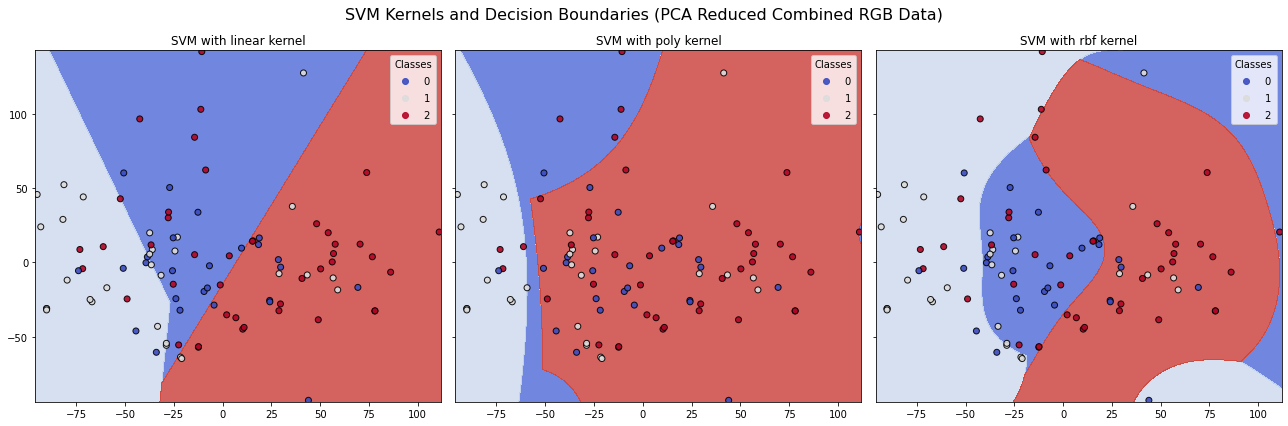

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def plot_decision_boundary(X, y, model, ax, title):
    """
    Plot the decision boundary for an SVM model.

    Args:
        X (np.ndarray): 2D feature array.
        y (np.ndarray): Encoded labels.
        model: Trained SVM model.
        ax: Matplotlib axis.
        title (str): Title for the plot.
    """
    h = 0.05  # Step size for the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.coolwarm, alpha=0.9)
    ax.set_title(title, fontsize=12)
    ax.legend(*scatter.legend_elements(), title="Classes")

def visualize_kernel_effect(X_rgb, y_encoded, categories, test_size=0.2, random_state=42):
    """
    Visualize the effect of SVM kernels on combined RGB data using PCA for dimensionality reduction.

    Args:
        X_rgb (np.ndarray): Combined RGB data.
        y_encoded (np.ndarray): Encoded labels.
        categories (list): List of category names.
        test_size (float): Proportion of the data to include in the test set.
        random_state (int): Random state for reproducibility.
    """
    # Normalize and reduce to 2D using PCA
    print("Normalizing and reducing data with PCA...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_rgb)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=test_size, random_state=random_state
    )

    # Train SVM models with different kernels
    kernels = ['linear', 'poly', 'rbf']
    print("Training SVM models with kernels:", kernels)

    # Visualize decision boundaries for all kernels
    fig, axes = plt.subplots(1, len(kernels), figsize=(18, 6), sharex=True, sharey=True)
    for idx, kernel in enumerate(kernels):
        model = SVC(kernel=kernel, gamma='scale', random_state=random_state)
        model.fit(X_train, y_train)
        plot_decision_boundary(X_test, y_test, model, axes[idx], f"SVM with {kernel} kernel")

    plt.suptitle("SVM Kernels and Decision Boundaries (PCA Reduced Combined RGB Data)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize kernel effect using combined RGB data
print("Visualizing the effect of kernels using combined RGB data...")
visualize_kernel_effect(X_rgb, y_encoded, categories, test_size=0.2, random_state=42)

Now, we initialise our SVM model with our kernel of choice. We use the scikit learn library to set our model up.

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import numpy as np

def svm_model(X, y, categories, rand_states, kernel="rbf", plot_confusion=True,
              plot_metrics=True, log_optimization=False, test_size=0.20):
    """
    Train and evaluate an SVM model with optional optimization logs and visualizations.

    Args:
    X (np.ndarray): Feature matrix.
    y (np.ndarray): Target labels.
    categories (list): List of categories for comparison.
    rand_states (list): Random states for reproducibility.
    kernel (str): SVM kernel type (default: "rbf").
    plot_confusion (bool): Toggle for plotting confusion matrices.
    plot_metrics (bool): Toggle for plotting F1 score comparison.
    log_optimization (bool): Toggle for optimization logs during training.
    test_size (float): Proportion of the dataset for the test set.

    Returns:
    dict: Dictionary of metrics for each category and random state.
    """
    results = defaultdict(list)

    for target_category in categories:
        binary_y = np.where(y == target_category, 1, 0)

        for rand_state in rand_states:
            # Split the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, binary_y,
                                                                test_size=test_size, random_state=rand_state)

            # Train the SVM model with simulated logging
            if log_optimization:
                print(f"\nTraining SVM for category '{target_category}', random state {rand_state}...")

            model = SVC(kernel=kernel, probability=True, random_state=rand_state)
            model.fit(X_train, y_train)

            if log_optimization:
                print(f"Optimization complete for category '{target_category}', random state {rand_state}.")

            # Predict and calculate metrics
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            recall = recall_score(y_test, predictions, zero_division=1)
            f1 = f1_score(y_test, predictions, zero_division=1)
            cm = confusion_matrix(y_test, predictions)

            # Store results
            results[target_category].append({
                'random_state': rand_state,
                'accuracy': accuracy,
                'recall': recall,
                'f1_score': f1,
                'confusion_matrix': cm
            })

    # Visualizations
    if plot_metrics:
        model_results = {"SVM": results}
        plot_f1_score_comparison(model_results, categories, rand_states)

    if plot_confusion:
        plot_confusion_matrices_side_by_side_all_categories({"SVM": results}, categories, rand_states, ["SVM"])
    '''
    # Print metrics
    for category, metrics in results.items():
        print(f"--- {category} ---")
        for metric in metrics:
            print(f"Random State: {metric['random_state']}, "
                  f"Accuracy: {metric['accuracy']:.2f}, "
                  f"Recall: {metric['recall']:.2f}, "
                  f"F1-Score: {metric['f1_score']:.2f}")
        print()
    '''

    return results

### CNN

We initialise our CNN model by stacking convolutional layers with ReLU activations and max-pooling layers for feature extraction. Our convolution layers have a 3x3 kernel with a ReLU activationfucntion. The maxpooling layer is reduces the filter to 2x2. Then, our we use a flatten layer to convert our output into a one-dimensional vector that is passed through our dense layer. Additionally, we use a 50% dropout layer to prevent overfitting. Finally our 128-neurons dense layer processes the vector and produces a binary classification output with a sigmoid activation function.

In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict


def cnn_model(X, y, categories, rand_states, plot_confusion=True, plot_metrics=True, log_optimization=False, test_size=0.20, epochs=10, batch_size=32):
    """
    Train and evaluate a CNN model with optional logs and visualizations.

    Args:
    X (np.ndarray): Feature matrix (reshaped for CNN).
    y (np.ndarray): Target labels.
    categories (list): List of categories for comparison.
    rand_states (list): Random states for reproducibility.
    plot_confusion (bool): Toggle for plotting confusion matrices.
    plot_metrics (bool): Toggle for plotting F1 score comparison.
    log_optimization (bool): Toggle for optimization logs during training.
    test_size (float): Proportion of the dataset for the test set.
    epochs (int): Number of training epochs.
    batch_size (int): Batch size for training.

    Returns:
    dict: Dictionary of metrics for each category and random state.
    """
    results = defaultdict(list)

    # Prepare data
    X_cnn = X.reshape(-1, 64, 64, 3).astype(np.float32)
    label_to_index = {label: idx for idx, label in enumerate(categories)}
    y_encoded = np.array([label_to_index[label] for label in y])

    for target_category in categories:
        binary_y = np.where(y == target_category, 1, 0)

        for rand_state in rand_states:
            # Split the dataset
            X_train, X_test, y_train, y_test = train_test_split(X_cnn, binary_y,
                                                                test_size=test_size, random_state=rand_state)

            # Create CNN model
            model = Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(128, activation='relu'),
                Dropout(0.5),
                Dense(1, activation='sigmoid')  # Sigmoid for binary classification
            ])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            if log_optimization:
                print(f"\nTraining CNN for category '{target_category}', random state {rand_state}...")

            # Train the model
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1 if log_optimization else 0)

            if log_optimization:
                print(f"Optimization complete for category '{target_category}', random state {rand_state}.")

            # Predict and calculate metrics
            y_pred = (model.predict(X_test) >= 0.5).astype(int).flatten()
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, zero_division=1)
            f1 = f1_score(y_test, y_pred, zero_division=1)
            cm = confusion_matrix(y_test, y_pred)

            # Store results
            results[target_category].append({
                'random_state': rand_state,
                'accuracy': accuracy,
                'recall': recall,
                'f1_score': f1,
                'confusion_matrix': cm
            })

    # Visualizations
    if plot_metrics:
        model_results = {"CNN": results}
        plot_f1_score_comparison(model_results, categories, rand_states)

    if plot_confusion:
        plot_confusion_matrices_side_by_side_all_categories({"CNN": results}, categories, rand_states, ["CNN"])
    '''
    # Print metrics
    for category, metrics in results.items():
        print(f"--- {category} ---")
        for metric in metrics:
            print(f"Random State: {metric['random_state']}, "
                  f"Accuracy: {metric['accuracy']:.2f}, "
                  f"Recall: {metric['recall']:.2f}, "
                  f"F1-Score: {metric['f1_score']:.2f}")
        print()
    '''

    return results

### Transfer Learning: ResNet50

We set up a transfer learning model by using the ResNet50 model trained on the ImageNet dataset. ResNet50 is our base model. We freeze its convolutional layers to retain their pre-trained knowledge. Then, we add a global average pooling layer to reduce the feature maps from the base model to a single vector. Similarly to CNN, we use a 20% dropout layer to prevent overfitting. Finally, we add a Dense layer with a sigmoid activation function to produce a binary classification output.

In [26]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def transfer_learning_resnet(X, y, categories, rand_states, plot_confusion=True, plot_metrics=True, log_optimization=False, test_size=0.20, epochs=5):
    """
    Perform transfer learning with ResNet50, evaluate metrics, and optionally visualize results.

    Parameters:
    X: np.ndarray
        Input images, reshaped to (height, width, channels).
    y: np.ndarray
        Target labels.
    categories: list
        List of target categories for comparison.
    rand_states: list
        List of random states for reproducibility.
    plot_confusion: bool
        Whether to plot confusion matrices.
    plot_metrics: bool
        Whether to plot metrics trends across random states.
    log_optimization: bool
        Whether to log the training process.
    test_size: float
        Proportion of the dataset to include in the test split.
    epochs: int
        Number of training epochs.

    Returns:
    dict: Dictionary containing metrics for each category and random state.
    """
    results = defaultdict(list)
    input_shape = (224, 224, 3)

    # Resize images to ResNet50's expected input shape
    X_resized = np.array([tf.image.resize(img.reshape(64, 64, 3), (224, 224)).numpy() for img in X])

    for target_category in categories:
        binary_y = np.where(y == target_category, 1, 0)

        for rand_state in rand_states:
            X_train, X_test, y_train, y_test = train_test_split(X_resized, binary_y, test_size=test_size, random_state=rand_state)

            # Data augmentation
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True
            )
            train_gen = datagen.flow(X_train, y_train, batch_size=32)

            # Build the Transfer Learning Model
            base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
            base_model.trainable = False  # Freeze pre-trained layers

            inputs = tf.keras.Input(shape=input_shape)
            x = base_model(inputs, training=False)
            x = GlobalAveragePooling2D()(x)
            x = Dropout(0.2)(x)
            outputs = Dense(1, activation="sigmoid")(x)  # For binary classification
            model = Model(inputs, outputs)
            model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

            if log_optimization:
                print(f"\nTraining ResNet50 for category '{target_category}', random state {rand_state}...")

            # Train the model
            model.fit(train_gen, epochs=epochs, verbose=1 if log_optimization else 0)

            # Predict and calculate metrics
            predictions = (model.predict(X_test) > 0.5).astype(int)
            accuracy = accuracy_score(y_test, predictions)
            recall = recall_score(y_test, predictions, zero_division=1)
            f1 = f1_score(y_test, predictions, zero_division=1)
            cm = confusion_matrix(y_test, predictions)

            # Store results
            results[target_category].append({
                "random_state": rand_state,
                "accuracy": accuracy,
                "recall": recall,
                "f1_score": f1,
                "confusion_matrix": cm
            })

    # Visualizations
    if plot_metrics:
        model_results = {"ResNet50": results}
        plot_f1_score_comparison(model_results, categories, rand_states)

    if plot_confusion:
        plot_confusion_matrices_side_by_side_all_categories(
            {"ResNet50": results}, categories, rand_states, ["ResNet50"]
        )
    '''
    # Print metrics
    for category, metrics in results.items():
        print(f"--- {category} ---")
        for metric in metrics:
            print(f"Random State: {metric['random_state']}, "
                  f"Accuracy: {metric['accuracy']:.2f}, "
                  f"Recall: {metric['recall']:.2f}, "
                  f"F1-Score: {metric['f1_score']:.2f}")
        print()'''

    return results

## Models results comparisons

Now, we test our model by checking the code on two random states for each model. We create an array for the grayscale values and one for the RGB values.

In [ ]:
categories = ["City", "Nature", "Beach"]

# Use the normalized grayscale DataFrame
df_normalized_gray = normalized_dataframes["Grayscale"]

# Separate the DataFrame into X (features) and y (labels)
X = df_normalized_gray.drop(columns=["label"]).values  # Features
y = df_normalized_gray["label"].values  # Labels

In [ ]:
import pandas as pd
import numpy as np

def create_combined_rgb(dataframes, categories):
    """
    Combines the RGB components into a single feature matrix for SVM visualization.

    Args:
        dataframes (dict): Dictionary containing separate DataFrames for 'Red', 'Green', and 'Blue'.
        categories (list): List of category names.

    Returns:
        tuple: Combined RGB feature matrix (X_rgb) and encoded labels (y_encoded).
    """
    print("Combining RGB components into a single feature matrix...")

    # Extract individual components
    df_red = dataframes["Red"].drop(columns=["label"])
    df_green = dataframes["Green"].drop(columns=["label"])
    df_blue = dataframes["Blue"].drop(columns=["label"])
    
    # Ensure labels are consistent across components
    labels = dataframes["Red"]["label"].values
    assert all(labels == dataframes["Green"]["label"].values)
    assert all(labels == dataframes["Blue"]["label"].values)

    # Combine RGB components into a single feature matrix
    X_rgb = np.hstack((df_red.values, df_green.values, df_blue.values))

    # Encode labels as integers
    label_to_index = {label: idx for idx, label in enumerate(categories)}
    y_encoded = np.array([label_to_index[label] for label in labels])

    print(f"Shape of combined RGB matrix: {X_rgb.shape}")
    return X_rgb, y_encoded

# Create combined X_rgb and y
categories = ['City', 'Beach', 'Nature']
X_rgb, y_encoded = create_combined_rgb(normalized_dataframes, categories)

### Logistic Regression

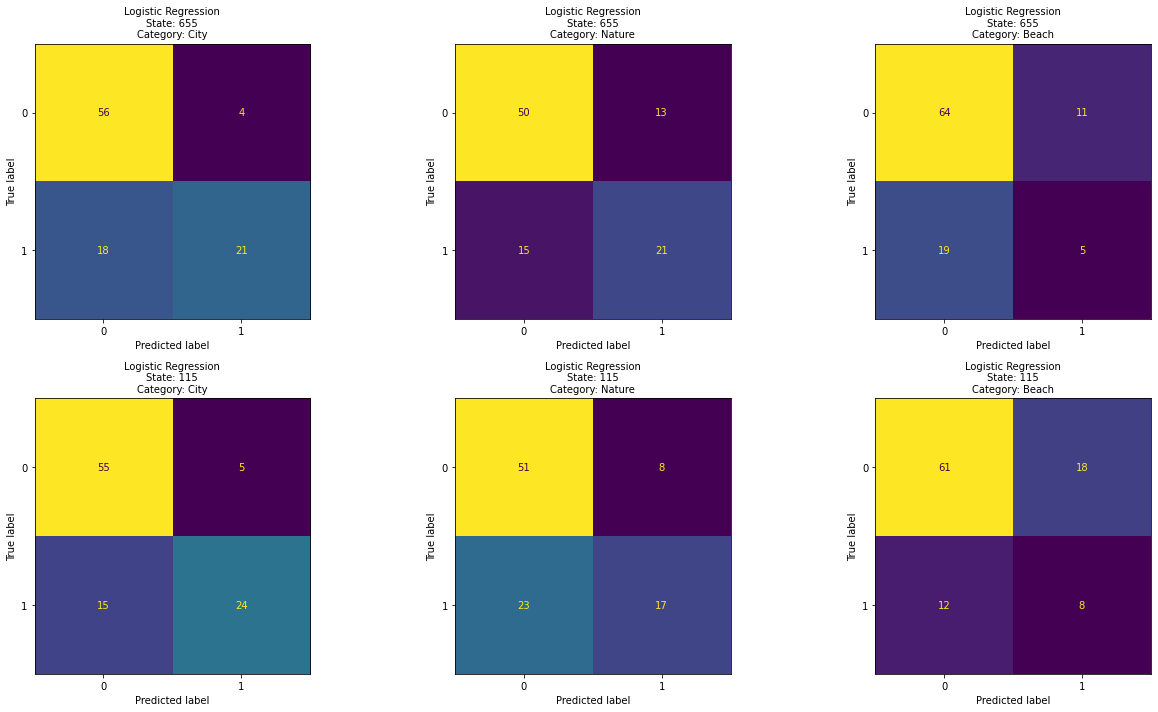

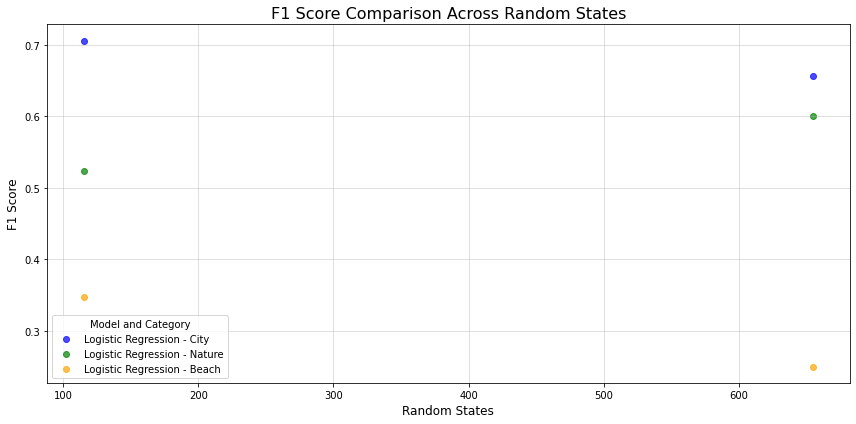

In [30]:
# Set the random seed for reproducibility

random_seed = 42
random.seed(random_seed)

# Generate 100 random states
random_states = random.sample(range(1, 1000), 2)

# Perform logistic regression with enhanced metrics and confusion matrices in a grid
logistic_results = logistic_regression(
    X, y, categories=categories,
    rand_states=random_states,
    plot_confusion=True,
    plot_metrics=True,
    print_cost=True
)

### SVM with Kernel trick

Training and Evaluating SVM with Optimization Logs...

Training SVM for category 'City', random state 655...
Optimization complete for category 'City', random state 655.

Training SVM for category 'City', random state 115...
Optimization complete for category 'City', random state 115.

Training SVM for category 'Nature', random state 655...
Optimization complete for category 'Nature', random state 655.

Training SVM for category 'Nature', random state 115...
Optimization complete for category 'Nature', random state 115.

Training SVM for category 'Beach', random state 655...
Optimization complete for category 'Beach', random state 655.

Training SVM for category 'Beach', random state 115...
Optimization complete for category 'Beach', random state 115.


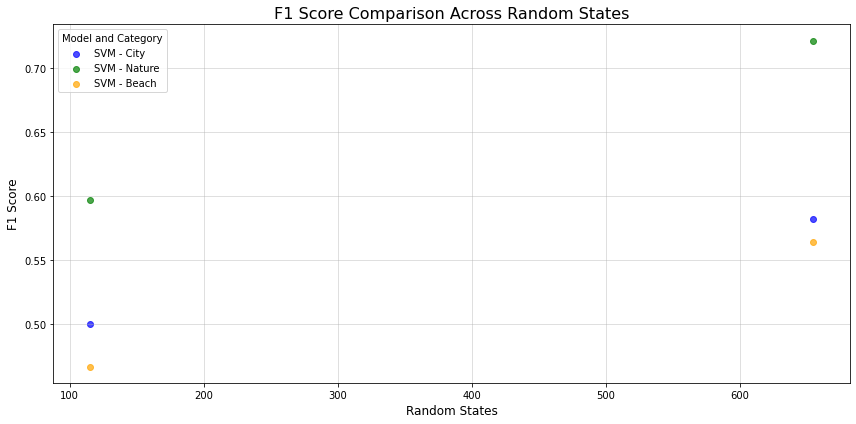

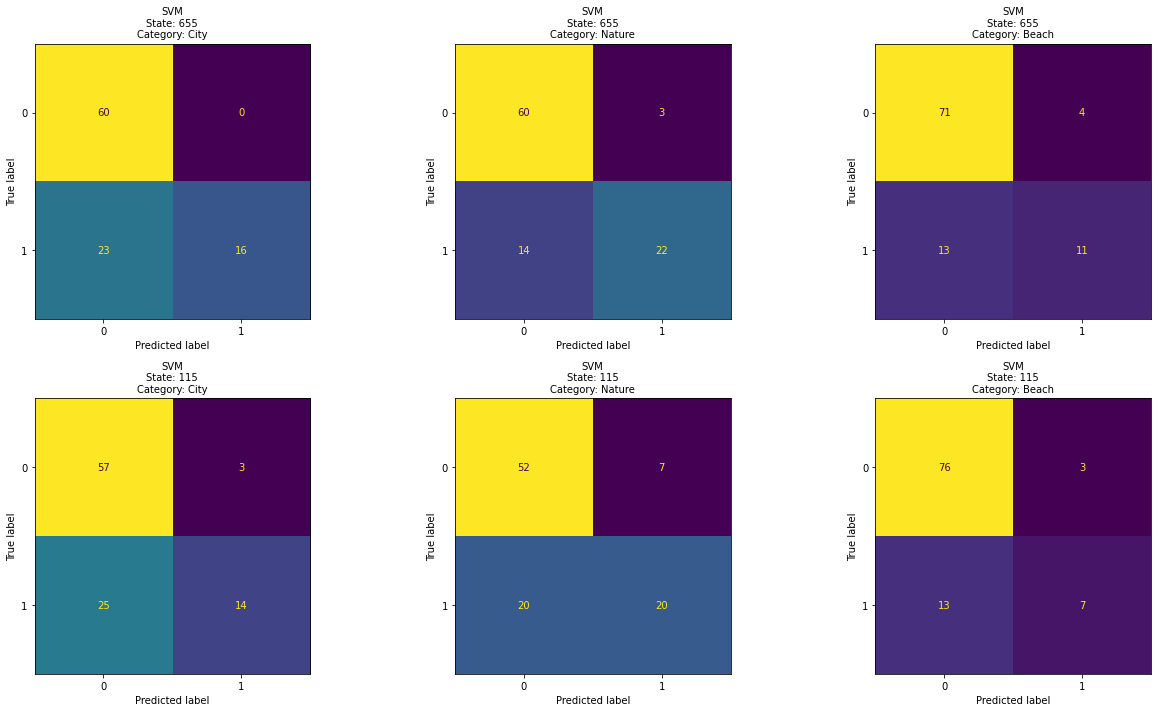

In [31]:
# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Target categories
categories = ["City", "Nature", "Beach"]

# Generate 100 random states
random_states = random.sample(range(1, 1000), 2)

print("Training and Evaluating SVM with Optimization Logs...")
svm_results = svm_model(
    X, y, categories, random_states,
    kernel="rbf",
    plot_confusion=True,
    plot_metrics=True,
    log_optimization=True
)

### CNN


Training CNN for category 'Beach', random state 655...
Optimization complete for category 'Beach', random state 655.
4/4 [==============================] - 0s 9ms/step

Training CNN for category 'Beach', random state 115...
Optimization complete for category 'Beach', random state 115.
4/4 [==============================] - 0s 9ms/step

Training CNN for category 'City', random state 655...
Optimization complete for category 'City', random state 655.
4/4 [==============================] - 0s 10ms/step

Training CNN for category 'City', random state 115...
Optimization complete for category 'City', random state 115.
4/4 [==============================] - 0s 9ms/step

Training CNN for category 'Nature', random state 655...
Optimization complete for category 'Nature', random state 655.
4/4 [==============================] - 1s 12ms/step

Training CNN for category 'Nature', random state 115...
Optimization complete for category 'Nature', random state 115.
4/4 [==============================

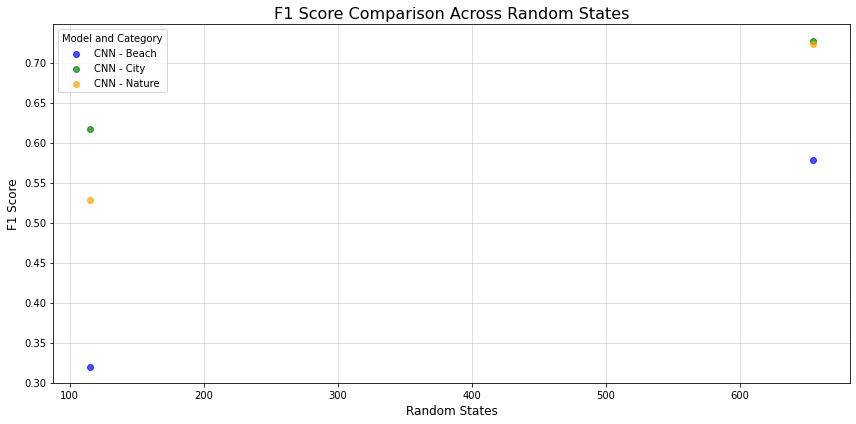

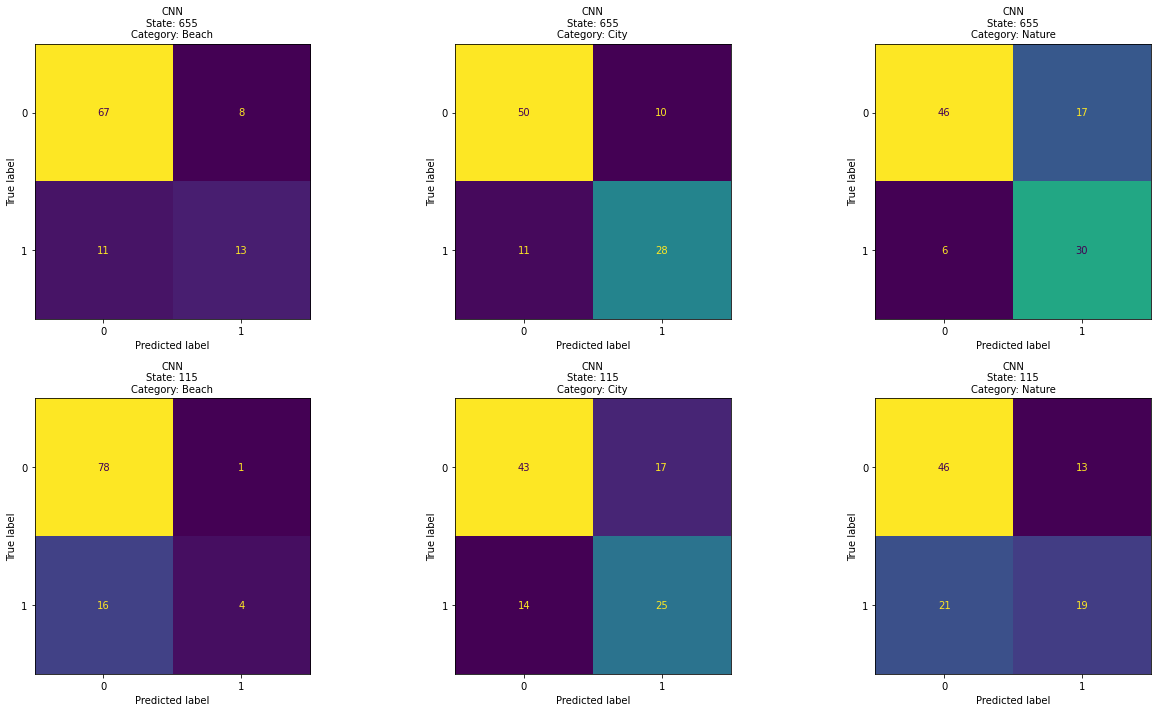

In [32]:
# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Target categories
categories = ["City", "Nature", "Beach"]

# Generate 100 random states
random_states = random.sample(range(1, 1000), 2)

cnn_results = cnn_model(
    X_rgb, y, 
    categories=["Beach", "City", "Nature"], 
    rand_states=random_states, 
    plot_confusion=True, 
    plot_metrics=True, 
    log_optimization=True, 
    test_size=0.2, 
    epochs=10, 
    batch_size=32
)

### Transfer Learning: ResNet50

Training and evaluating ResNet50 with transfer learning...

Training ResNet50 for category 'Beach', random state 204...
Epoch 1/5
13/13 [==============================] - 24s 2s/step - loss: 0.6588 - accuracy: 0.6794
Epoch 2/5
13/13 [==============================] - 20s 2s/step - loss: 0.4680 - accuracy: 0.7837
Epoch 3/5
13/13 [==============================] - 21s 2s/step - loss: 0.3738 - accuracy: 0.8448
Epoch 4/5
13/13 [==============================] - 21s 2s/step - loss: 0.3327 - accuracy: 0.8524
Epoch 5/5
4/4 [==============================] - 6s 1s/step

Training ResNet50 for category 'Beach', random state 734...
Epoch 1/5
13/13 [==============================] - 23s 2s/step - loss: 0.7612 - accuracy: 0.6387
Epoch 2/5
13/13 [==============================] - 22s 2s/step - loss: 0.4839 - accuracy: 0.7888
Epoch 3/5
13/13 [==============================] - 21s 2s/step - loss: 0.4371 - accuracy: 0.8041
Epoch 4/5
13/13 [==============================] - 20s 2s/step - loss: 0.3871 - 

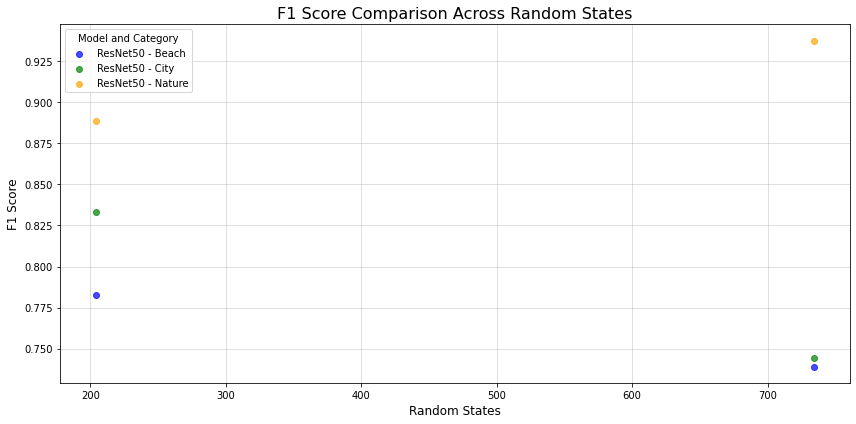

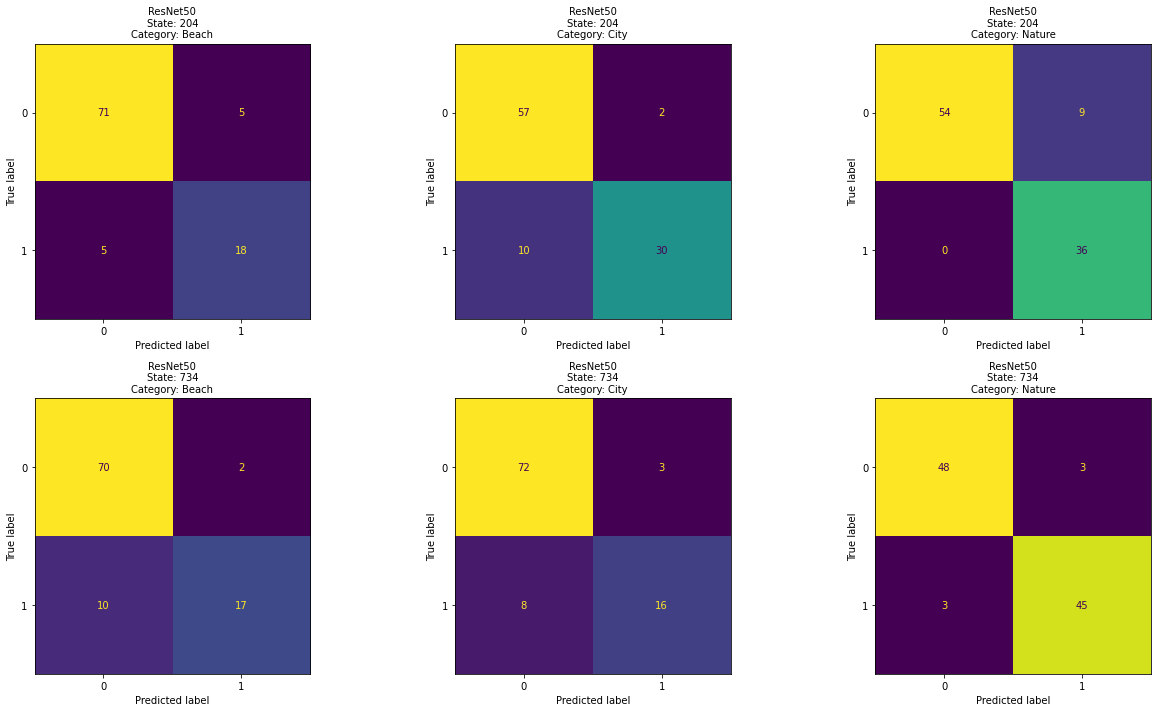

In [33]:
categories = ["Beach", "City", "Nature"]
random_states = random.sample(range(1, 1000), 2)

print("Training and evaluating ResNet50 with transfer learning...")
transfer_learning_resnet = transfer_learning_resnet(
    X_rgb, y, 
    categories=categories, 
    rand_states=random_states,
    plot_confusion=True,
    plot_metrics=True,
    log_optimization=True
)

## Results discussion

The logistic regression performs mostly okay to poorly. It can tell images from a city better apart from the rest, but it is not especially good. Additionally, the maximum F1 score we see is of 0.7. On the other hand, the SVM performs slightly better as the F1 scores are less spread out, but the maximum is still 0.7. Furthermore, it also starts to separate nature images. It is thus better to classify two categories while the logistic regression is only suitable for one.

Now, the CNNs. Our CNN does not necessarily perform much better as the max F1 score is still .7. It can still tell the city category apart better, but it is not as good as the SVM was for the Nature category. Finally, the RESNet50 model performs much better as the minimum F1 score is a little under .075, and the maximum reaches almost .93. It seems way better to tell the nature category apart than any other models. Still, it tells the city category apart pretty well.

Finally, the ResNet50 model and the SVM are the best overall for the Beach category. However, they do not perform exceptionally well. We assume this arises from beach images with the most illumination range and easily blended features. The beach images have plenty of sunset and bright sun images, making them somewhat inconsistent. Additionally, a few shapes represent the beach, as nature can have trees and cities can have buildings.

## Conclusions

We have implemented several models to our dataset and can conclude that the hardest-to-tell-apart category is the Beach category. On the other hand, the best-performing model is the ResNet50, as we expected. This model has been pre-trained on a substantially larger dataset and can perform pretty well on image classification by feature detection.

Finally, we should note that our CNN trained from scratch does not have the ResNet50 performance, but we believe it is not as bad given it was taught in such a comparatively small dataset and from scratch.

For an expansion, we could explore more random states to ensure our conclusions are robust and hyperparameter tuning for all our models to make them perform even better.

# Executive Summary

This project explores the development of a robust image classification pipeline capable of distinguishing between three categories: Beach, City, and Nature. We began by pre-processing the dataset through normalization and RGB component separation. We have implemented four increasingly better machine learning and deep learning models. They are Logistic Regression, Support Vector Machines (SVMs), Convolutional Neural Networks (CNNs), and Transfer Learning using ResNet50.

Each model was trained, optimized, and assessed using accuracy, F1-score, recall, and confusion matrices. Key advancements include kernel optimization in SVMs and fine-tuning a ResNet50 model for high-dimensional image data. The comparative analysis highlighted the ResNet50 model’s superiority in handling intricate spatial features and delivering better performance.

This pipeline demonstrated the importance of pre-processing, model selection, and systematic evaluation in achieving state-of-the-art classification accuracy for complex datasets. This work serves as a foundation for future enhancements and real-world deployment.

# AI Statement

I used the LLM Chat GPT to generate code shells then revised and improved by me. Additionally, the mathematical formulas and pseudo algorithms shells were provided by the LLM, but we proofread them and adapted them to our specific project. Finally, we used Grammarly to proofread the assignment. 